Dataset Preparation


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/kaggle-cat-vs-dog-dataset


In [2]:
import os
import random
import shutil
from PIL import Image

def split_and_copy_images(src_dir, base_dst, class_name, split_ratio=(0.7, 0.15, 0.15), max_images=2400):
    class_dir = os.path.join(src_dir, class_name)
    files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    random.shuffle(files)

    num_total = min(len(files), max_images)
    num_train = int(split_ratio[0] * num_total)
    num_val = int(split_ratio[1] * num_total)
    num_test = num_total - num_train - num_val

    subsets = {
        'train': files[:num_train],
        'val': files[num_train:num_train+num_val],
        'test': files[num_train+num_val:num_total]
    }

    for subset, file_list in subsets.items():
        dst_dir = os.path.join(base_dst, subset, class_name)
        os.makedirs(dst_dir, exist_ok=True)
        count = 0
        for fname in file_list:
            src_path = os.path.join(class_dir, fname)
            dst_path = os.path.join(dst_dir, fname)
            try:
                with Image.open(src_path) as img:
                    img.verify()
                shutil.copy(src_path, dst_path)
                count += 1
            except:
                continue
        print(f"Copied {count} images to {dst_dir}")

base_data_dir = "/content/small_dataset"
src_dir = os.path.join(path, "kagglecatsanddogs_3367a", "PetImages")

split_and_copy_images(src_dir, base_data_dir, "Cat")
split_and_copy_images(src_dir, base_data_dir, "Dog")



Copied 1680 images to /content/small_dataset/train/Cat
Copied 360 images to /content/small_dataset/val/Cat
Copied 360 images to /content/small_dataset/test/Cat
Copied 1679 images to /content/small_dataset/train/Dog
Copied 360 images to /content/small_dataset/val/Dog
Copied 360 images to /content/small_dataset/test/Dog


In [3]:
# Imports
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Paths and Parameters
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 24
BASE_DIR = "/content/drive/MyDrive/DLProject/data"


Data Preprocessing

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Justification:
# - rescale: Normalizes pixel values to [0, 1] (helps faster convergence)
# - rotation/zoom/flip: Increases model robustness (augment small dataset)
# - validation_split: Reserve 20% data for validation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    directory=os.path.join(base_data_dir, "train"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_gen = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_data_dir, "val"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_data_dir, "test"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)



Found 3359 images belonging to 2 classes.
Found 720 images belonging to 2 classes.
Found 720 images belonging to 2 classes.


Building the CNN Model

In [5]:
!pip install --upgrade scikeras scikit-learn

In [17]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from scikeras.wrappers import KerasClassifier

def build_model(optimizer='adam', dropout_rate=0.5, num_filters=32, num_conv_layers=1, kernel_size=(3, 3)):
    model = Sequential()
    model.add(Conv2D(num_filters, kernel_size, activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D((2, 2)))

    for _ in range(num_conv_layers - 1):  # Add extra conv layers if needed
        model.add(Conv2D(num_filters, kernel_size, activation='relu'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


Training the Model

In [ ]:
# Train the CNN
import itertools
import numpy as np

param_grid = {
    'dropout_rate': [0.3, 0.5],
    'num_filters': [32, 64],
    'num_conv_layers': [1, 2],
    'kernel_size': [(3, 3), (5, 5)]
}



best_accuracy = 0
best_model = None
best_params = {}

for params in itertools.product(*param_grid.values()):
    config = dict(zip(param_grid.keys(), params))
    print(f"\nTraining with params: {config}")

    model = build_model(
        optimizer=config['optimizer'],
        dropout_rate=config['dropout_rate'],
        num_filters=config['num_filters'],
        num_conv_layers=config['num_conv_layers'],
        kernel_size=config['kernel_size']
    )

    history = model.fit(
        train_gen,
        epochs=24,
        validation_data=val_gen,
        verbose=1
    )

    val_acc = history.history['val_accuracy'][-1]
    print(f"Validation accuracy: {val_acc:.4f}")

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_model = model
        best_params = config

print("\nBest hyperparameters:")
print(best_params)
print(f"Best validation accuracy: {best_accuracy:.4f}")


Training with params: {'optimizer': 'adam', 'dropout_rate': 0.5, 'num_filters': 64, 'num_conv_layers': 2, 'kernel_size': (3, 3)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/24
105/105 ━━━━━━━━━━━━━━━━━━━━ 30s 251ms/step - accuracy: 0.4928 - loss: 0.9922 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/24
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 244ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/24
105/105 ━━━━━━━━━━━━━━━━━━━━ 25s 236ms/step - accuracy: 0.4961 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/24
105/105 ━━━━━━━━━━━━━━━━━━━━ 25s 235ms/step - accuracy: 0.5019 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/24
105/105 ━━━━━━━━━━━━━━━━━━━━ 25s 234ms/step - accuracy: 0.4943 - loss: 0.6931 - val_accuracy: 0.5056 - val_loss: 0.6938
Epoch 6/24
105/105 ━━━━━━━━━━━━━━━━━━━━ 24s 231ms/step - accuracy: 0.5750 - loss: 0.6872 - val_accuracy: 0.5500 - val_loss: 0.6843
Epoch 7/24
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.5778 - loss: 0.6804 - val_accuracy: 0.5903 - val_loss: 0.6666
Epoch 8/24
105/105 ━━━━━━━━━━━━━━━━━━━━ 25s 236ms/step - accuracy: 0.6097 - loss: 0

Accuracy/Loss Curves

In [19]:
# Predict class probabilities
y_true = test_gen.classes
y_pred_probs = best_model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


Classification Report:
              precision    recall  f1-score   support

         Cat       0.77      0.83      0.80       360
         Dog       0.81      0.76      0.79       360

    accuracy                           0.79       720
   macro avg       0.79      0.79      0.79       720
weighted avg       0.79      0.79      0.79       720



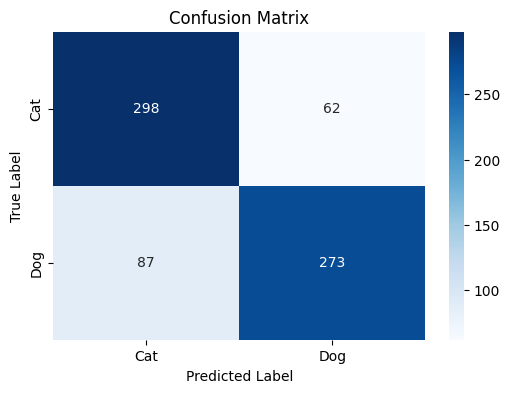

In [24]:
from sklearn.metrics import classification_report

# Print class names based on directory structure
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
loss, accuracy = best_model.evaluate(test_gen, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.7931


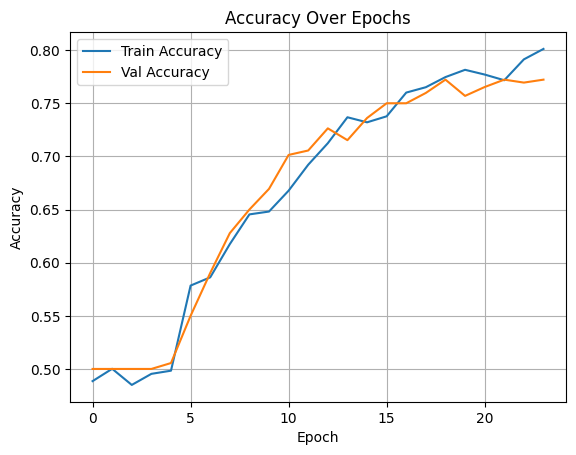

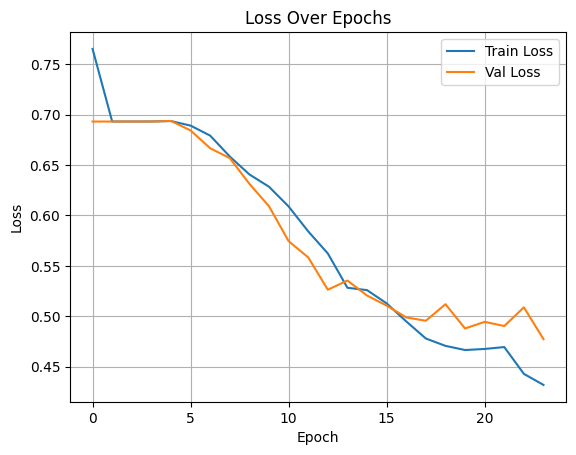

In [22]:
# Accuracy plot
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Performance Metrics and Confusion Matrix

In [1]:
# # Predictions
# y_true = val_gen.classes
# y_pred = (model.predict(val_gen) > 0.5).astype("int32").flatten()

# # Metrics
# print("\nClassification Report:\n")
# print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

# # Confusion Matrix
# cm = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(6, 5))
# plt.imshow(cm, cmap='Blues')
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.colorbar()
# plt.xticks([0, 1], ["Cat", "Dog"])
# plt.yticks([0, 1], ["Cat", "Dog"])
# plt.show()
